In [1]:
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
import math
import matplotlib.pyplot as plt
import sys
from collections import defaultdict
import itertools
import statistics
import random as r
r.seed(0)

In [2]:
def Get_Doc(doc):
    file = open(doc, "r")
    d = []
    for line in file:
        l = line.split("\t")
        t = []
        for i in l[1:]:
            t.append(float(i))
        d.append(t)
    return d

In [3]:
def Clusters(C1, type, title):
    plt.figure(figsize=(25, 10))
    plt.title(title)
    plt.xlabel("clusters")
    plt.ylabel("Distance")
    dendrogram(linkage(C1, type), leaf_rotation=90, leaf_font_size=10, show_leaf_counts=True)
    plt.show()
    return

In [4]:
def hirearchicalClustering():
    C1 = Get_Doc("C1.txt")
    #C2 = Get_Doc("C2.txt")
    #C3 = Get_Doc("C3.txt")
    Clusters(C1, "single", "Single-Link Cluster")
    Clusters(C1, "complete", "Complete-Link Cluster")
    Clusters(C1, "centroid", "Mean-Link Cluster")
    x = []
    y = []
    for i in C1:
        x.append(i[0])
        y.append(i[1])
    plt.scatter(x, y)
    plt.show()
    #print(C1)
    return

In [5]:
def Get_Distance(centroid, point):
    total = 0
    for i in range(len(centroid)):
        total = total + math.pow(centroid[i] - point[i], 2)
    return math.sqrt(total)

def Plot(clusters, title):
    colors = itertools.cycle(["r", "b", "g"])
    p = 1
    for key, value in clusters.items():
        x = []
        y = []
        for i in value:
            x.append(i[0])
            y.append(i[1])
        plt.scatter(x, y, color=next(colors))
        #print("Cluster " + str(p) + ":\t", end="")
        #print(value)
        p += 1
    plt.title(title)
    plt.show()
    return

In [6]:
def Gonzalez(C2, k, lloyds):
    centroids = []
    centroids.append(C2[0])
    for i in range(1, k+1):
        clusters = defaultdict(list)
        dist = [0, []]
        for i in C2:
            c = [sys.maxsize, []]
            for j in centroids:
                d = Get_Distance(j, i)
                if(d < c[0]):
                    c = [d, j]
            clusters[str(c[1])].append(i)
            d2 = Get_Distance(c[1], i)
            if(d2 > dist[0]):
                dist = [d2, i]
        centroids.append(dist[1])
    if (not lloyds):
        print(centroids)
        print("Total Cost: " + str(dist[0]))
        Plot(clusters, "Gonzalez")
    return centroids

In [7]:
def k_means(C2, k, recall, costs, lloyds):
    centroids = []
    centroids.append(C2[0])
    for p in range(1, k + 1):
        clusters = defaultdict(list)
        dist = [0, []]
        distances = []
        for i in C2:
            c = [sys.maxsize, []]
            for j in centroids:
                d = Get_Distance(j, i)
                if (d < c[0]):
                    c = [d, j]
            clusters[str(c[1])].append(i)
            d2 = Get_Distance(c[1], i)**2
            distances.append([d2, i])
        l = list(i[0] for i in distances)
        total = sum(l)
        distances2 = distances
        distances = list([i[0] / total, i[1]] for i in distances)
        number = np.random.rand()
        range1 = 0
        for i in distances:
            if(range1 < number <= range1 + i[0] and len(centroids) < k):
                centroids.append(i[1])
            range1 += i[0]
        cost = math.sqrt(sum(i[0] for i in distances2) / len(distances2))
    #print(centroids)
    #print("The cost is: " + str(cost))
    #Plot(clusters)
    if(lloyds):
        return centroids
    elif(recall != 0):
        costs.append(cost)
        return k_means(C2, k, recall - 1, costs, lloyds)
    else:
        Plot(clusters, "k-Means")
        Cumulative_Plot(costs)
        return

In [8]:
def Cumulative_Plot(costs):
    #print(costs)
    x = np.sort(costs)
    y = np.arange(1, len(x)+1) / len(x)
    plt.plot(x, y, marker='o', linestyle='-')
    plt.xlabel('Costs')
    plt.show()
    return

In [9]:
def Part2A():
    C2 = Get_Doc("C2.txt")
    print("Part 2A (Gonzalez)")
    Gonzalez(C2, 3, False)
    print("Part 2A (k-means)")
    costs = []
    k_means(C2, 3, 20, costs, False)
    return

In [10]:
def Get_Clusters(C2, centers):
    clusters = defaultdict(list)
    for i in C2:
        c = [sys.maxsize, []]
        for j in centers:
            d = Get_Distance(j, i)
            if (d < c[0]):
                c = [d, j]
        clusters[str(c[1])].append(i)
    return clusters

def Lloyds(C2, centers, title, kmeans):
    for z in range(10):
        clusters = Get_Clusters(C2, centers)
        new_centers = []
        for key, cluster in clusters.items():
             center = [0] * len(cluster[0])
             for i in cluster:
                 for j in range(len(cluster[0])):
                    center[j] = center[j] + i[j]
             center = list(i / len(cluster) for i in center)
             new_centers.append(center)
        centers = new_centers

    if(not kmeans):
        print("The new centers are: ")
        print(new_centers)
    new_clusters = Get_Clusters(C2, new_centers)
    if(not kmeans):
        Plot(new_clusters, title)

    dist = [0, []]
    distances = []
    for i in C2:
        c = [sys.maxsize, []]
        for j in new_centers:
            d = Get_Distance(j, i)
            if (d < c[0]):
                c = [d, j] # this is the [distance to its center, its center] for each point
        d2 = Get_Distance(c[1], i) ** 2
        distances.append([d2, i])
    cost = math.sqrt(sum(i[0] for i in distances) / len(distances))
    if(not kmeans):
        print("The total cost for " + title + " is: ")
        print(cost)
        return
    else:
        equal = True
        #for i in range(len(new_clusters)):
        for old_cluster, new_cluster in zip(clusters.values(), new_clusters.values()):
            for old_point, new_point in zip(old_cluster, new_cluster):
                for j in range(len(old_point)):
                    if old_point[j] != new_point[j]:
                        equal = False
        return cost, equal

In [11]:
def Part2B():
    C2 = Get_Doc("C2.txt")
    print("Part 2B (Lloyds)\n")
    print("C initially with points indexed {1, 2, 3}")
    Lloyds(C2, C2[:3], "Lloyds - Points Indexed at {1, 2, 3}", False)
    print("\nC initially as output of Gonzalez: ")
    Lloyds(C2, Gonzalez(C2, 3, True)[:3], "Lloyds - Points Indexed at Gonzalez", False)
    #print("\nC initially as output of k-means: ")
    costs = []
    cost = []
    j = 0
    for i in range(20):
        c, equal = Lloyds(C2, k_means(C2, 3, 0, cost, True), "Lloyds - Points Indexed at k-means", True)
        costs.append(c)
        if equal:
            j = j + 1
    print("A total of " + str(j / 20 * 100) + "% of the subsets are the same as the input")
    Cumulative_Plot(costs)
    return

In [12]:
# BONUS Question
def Write_To_File(centers):
    file = open("centers-" + str(len(centers)) + "-Median.txt", "w")
    st = ""
    i = 1
    for point in centers:
        st = st + str(i) + "\t"
        for coor in point:
            st = st + str(coor) + "\t"
        st = st + "\n"
        i += 1
    file.write(st)
    file.close()
    return

def k_median(C3, centers, title):
    for z in range(10):
        clusters = Get_Clusters(C3, centers)
        new_centers = []
        for key, cluster in clusters.items():
             center = []
             for j in range(len(cluster[0])):
                  center.append(np.median(list(i[j] for i in cluster)))
             new_centers.append(center)
        centers = new_centers

    print("The new centers are: ")
    print(new_centers)
    Write_To_File(new_centers)

    new_clusters = Get_Clusters(C3, new_centers)

    dist = [0, []]
    distances = []
    for i in C3:
        c = [sys.maxsize, []]
        for j in new_centers:
            d = Get_Distance(j, i)
            if (d < c[0]):
                c = [d, j] # this is the [distance to its center, its center] for each point
        d2 = Get_Distance(c[1], i)
        distances.append([d2, i])
    cost = sum(i[0] for i in distances) / len(distances)
    print("The total cost for " + title + " is: ")
    print(cost)
    return

In [13]:
def Part4():
    C3 = Get_Doc("C3.txt")
    costs = []
    k_median(C3, k_means(C3, 4, 0, costs, True), "4-median")
    return

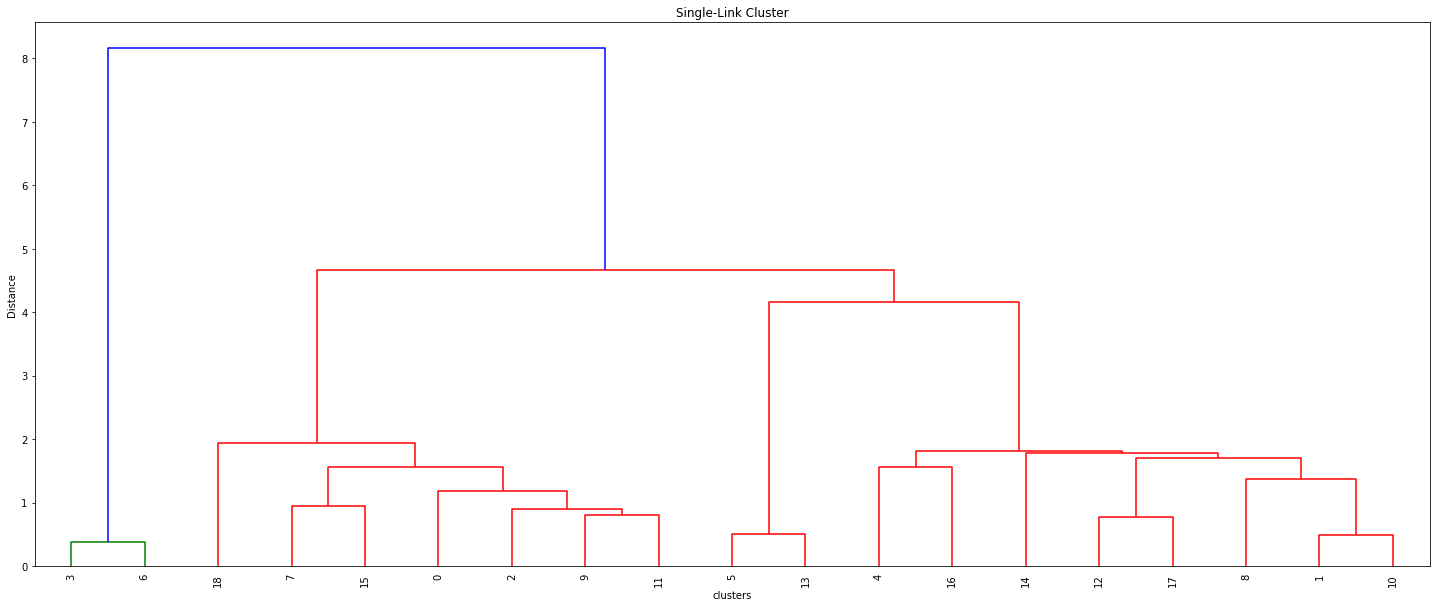

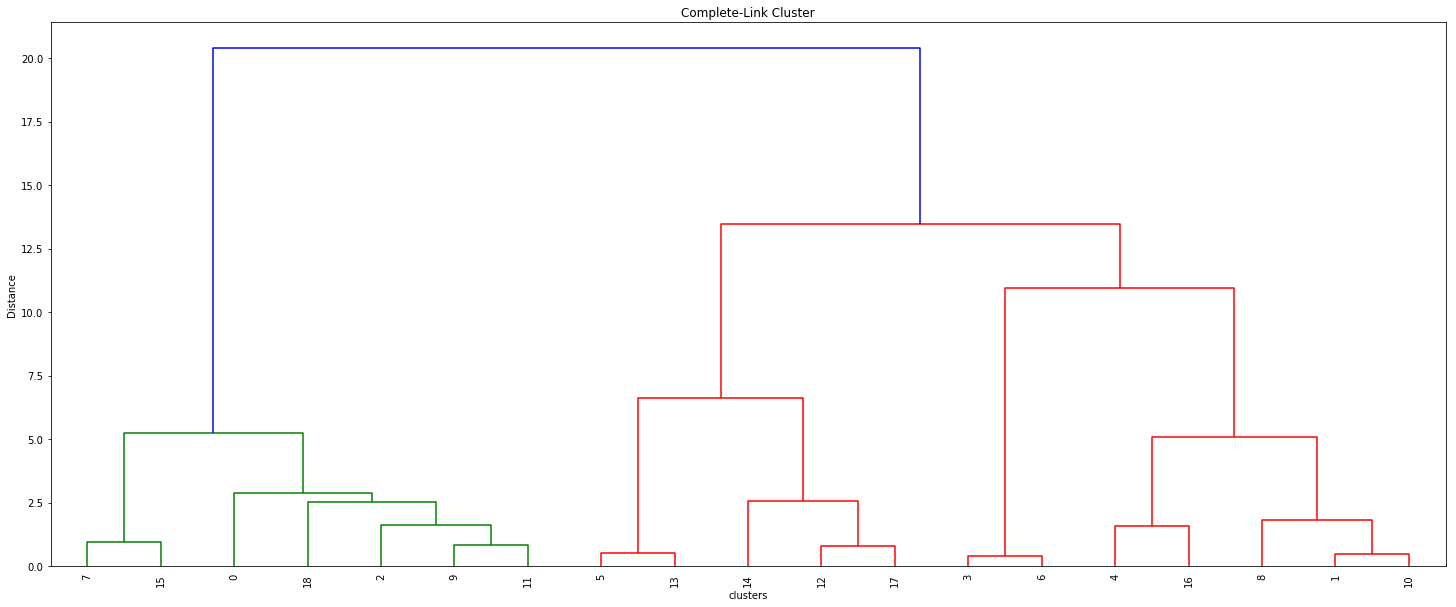

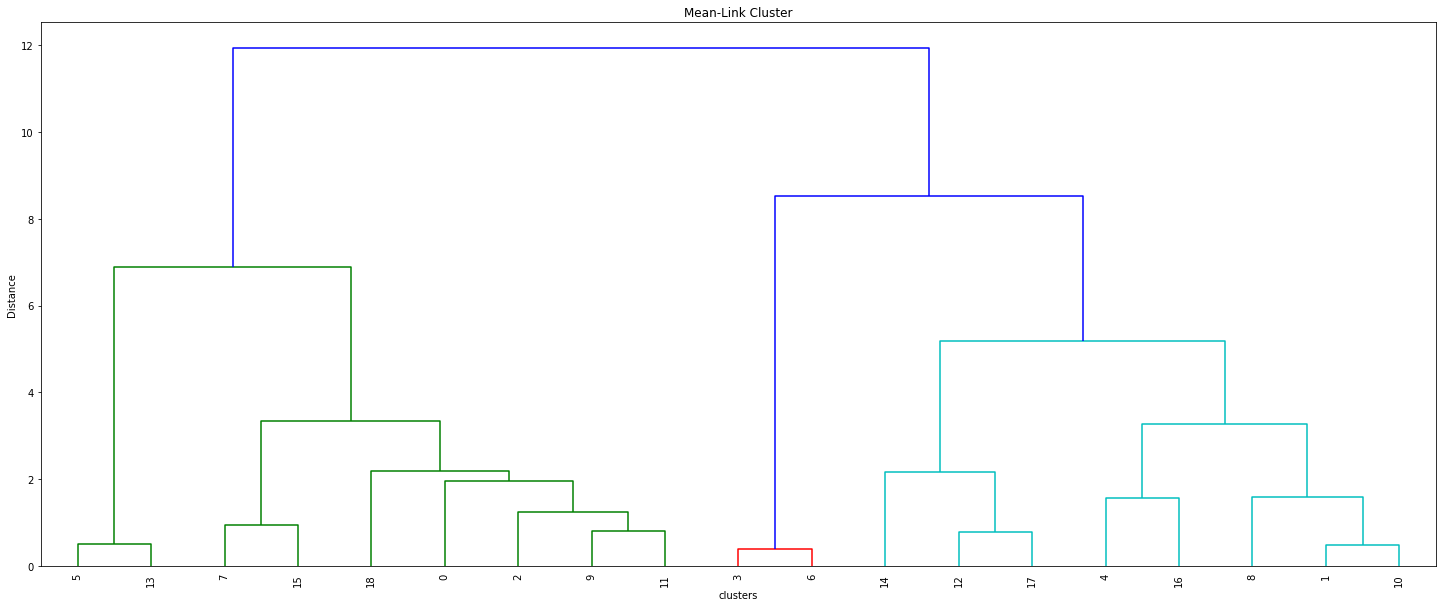

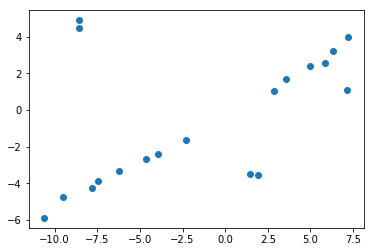

Part 2A (Gonzalez)
[[-4.4357274, -5.6060004], [0.0, -40.0], [5.1914717, 6.9736254], [0.2949466, 0.9379213]]
Total Cost: 7.7721092399481115


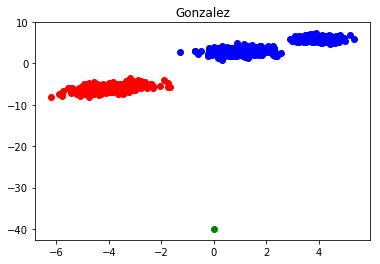

Part 2A (k-means)


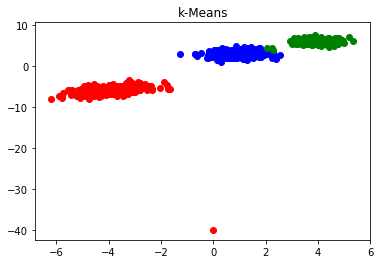

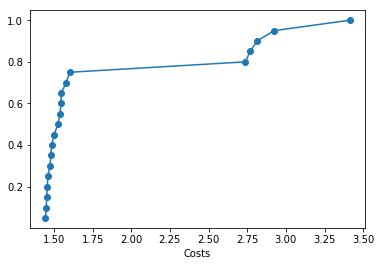

Part 2B (Lloyds)

C initially with points indexed {1, 2, 3}
The new centers are: 
[[-3.591641594827584, -5.561573005747129], [-4.55679247938931, -6.896134077099237], [2.4962886239455777, 4.470859188843542]]


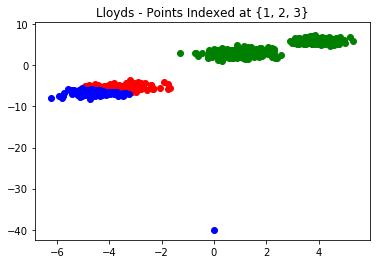

The total cost for Lloyds - Points Indexed at {1, 2, 3} is: 
2.2164314004616155

C initially as output of Gonzalez: 
The new centers are: 
[[-4.019360040460524, -6.0233791680921085], [2.4962886239455777, 4.470859188843542], [0.0, -40.0]]


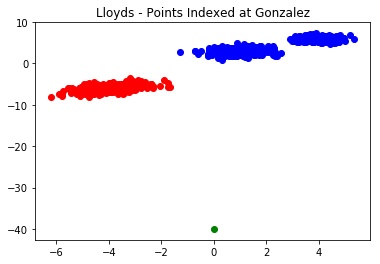

The total cost for Lloyds - Points Indexed at Gonzalez is: 
1.9964154472988538
A total of 100.0% of the subsets are the same as the input


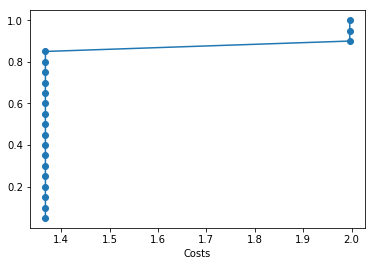

The new centers are: 
[[0.5562466, -0.00289925, 0.52895785, -0.009871, 0.01065005], [-0.01391795, 0.98616785, 0.0075185, 0.00345015, -0.003192], [-0.01053355, -0.00042669999999999996, 0.0040935, -0.0038091, 0.98873565], [0.0063873, -0.00284275, -0.00274625, 1.0133743, 0.00234675]]
The total cost for 4-median is: 
0.4279871867244618


In [14]:
def main():
    hirearchicalClustering()
    Part2A()
    Part2B()
    Part4()
    return

if __name__ == "__main__":
    main()
    exit(0)